In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import lifelines

## in this notebook, I'm going to examine some of the key features of lifeline, a package that is used for survival analysis.

In [15]:
from lifelines.datasets import load_regression_dataset
df = load_regression_dataset()
df.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1


In [16]:
df.describe()

,var1,var2,var3,T,E
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.880716,0.988642,0.929269,9.400928,0.945000
std,0.941356,0.905467,0.965086,3.572022,0.228552
min,0.000757,0.001644,0.001006,2.575538,0.000000
25%,0.228165,0.270389,0.257616,6.832556,1.000000
50%,0.603804,0.732779,0.558003,8.896869,1.000000
75%,1.245680,1.432956,1.333763,11.473951,1.000000
max,5.353937,4.048806,5.541838,21.939978,1.000000


#### Let's plot some of the data:

/home/yair/.local/lib/python3.10/site-packages/lifelines/plotting.py:773: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn(


<Axes: >

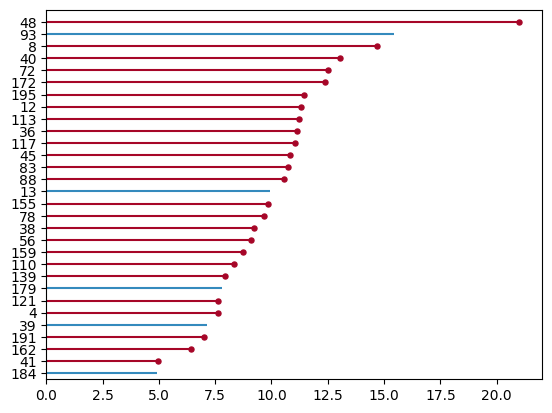

In [17]:
from lifelines.plotting import plot_lifetimes
df2 = df.sample(30)
plot_lifetimes(df2["T"],df2["E"])

#### Before we begin, Let's start by removing censored data (e.g: E=0). we'll come back for it later.

In [18]:
# Remove rows where E = 0 (censored data)
df_full = df
df = df[df['E'] == 1]

### Since we are working with survival data, let's try and see if our data fits the exponential distribution.

2.57553764605 6.8501643172175655


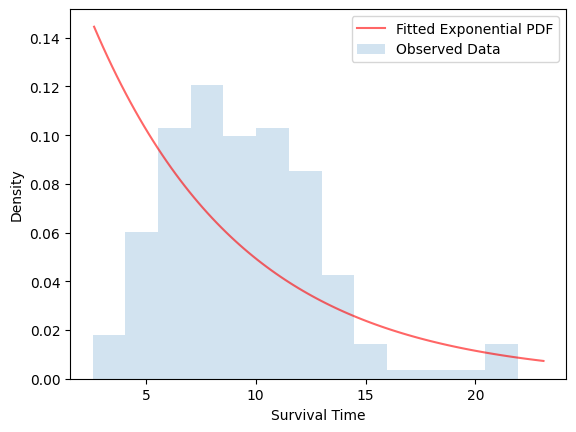

In [19]:
from scipy.stats import expon

# Fit the exponential distribution to the entire dataset
loc, scale = expon.fit(df["T"])
RV = expon(loc, scale)

# Print the fitted parameters
print(loc, scale)

# Generate values for plotting
x = np.linspace(RV.ppf(0.01), RV.ppf(0.95), 100)

# Plot the PDF of the exponential distribution
plt.plot(x, RV.pdf(x), 'r-', alpha=0.6, label='Fitted Exponential PDF')

# Plot the histogram of the observed survival times
plt.hist(df["T"], density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='Observed Data')

# Add labels and legend
plt.xlabel('Survival Time')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


#### Just from the look of our graph, we can see that it doesn't really fits an exponential distribution.

## Let's instroduce a new model, Weibull distribution. 

(1.8374344491124694, 3.265087450647137, 6.982311563086753)


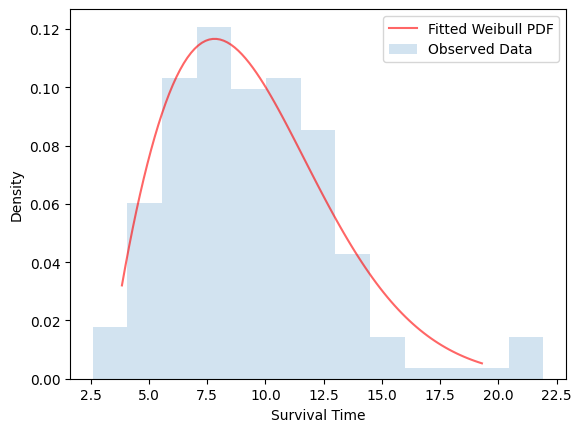

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Fit the Weibull distribution to the entire dataset
params = weibull_min.fit(df["T"])
RV = weibull_min(*params)

# Print the fitted parameters
print(params)

# Generate values for plotting
x = np.linspace(RV.ppf(0.01), RV.ppf(0.99), 100)

# Plot the PDF of the Weibull distribution
plt.plot(x, RV.pdf(x), 'r-', alpha=0.6, label='Fitted Weibull PDF')

# Plot the histogram of the observed survival times
plt.hist(df["T"], density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='Observed Data')

# Add labels and legend
plt.xlabel('Survival Time')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


#### We can see that our data does seems to come from a Weibull distribution.

### We can know check the hazarad rate and the survival function, for weibull and for exponential.

Exponential Parameters: (2.57553764605, 6.8501643172175655)
Weibull Parameters: (1.8374344491124694, 3.265087450647137, 6.982311563086753)


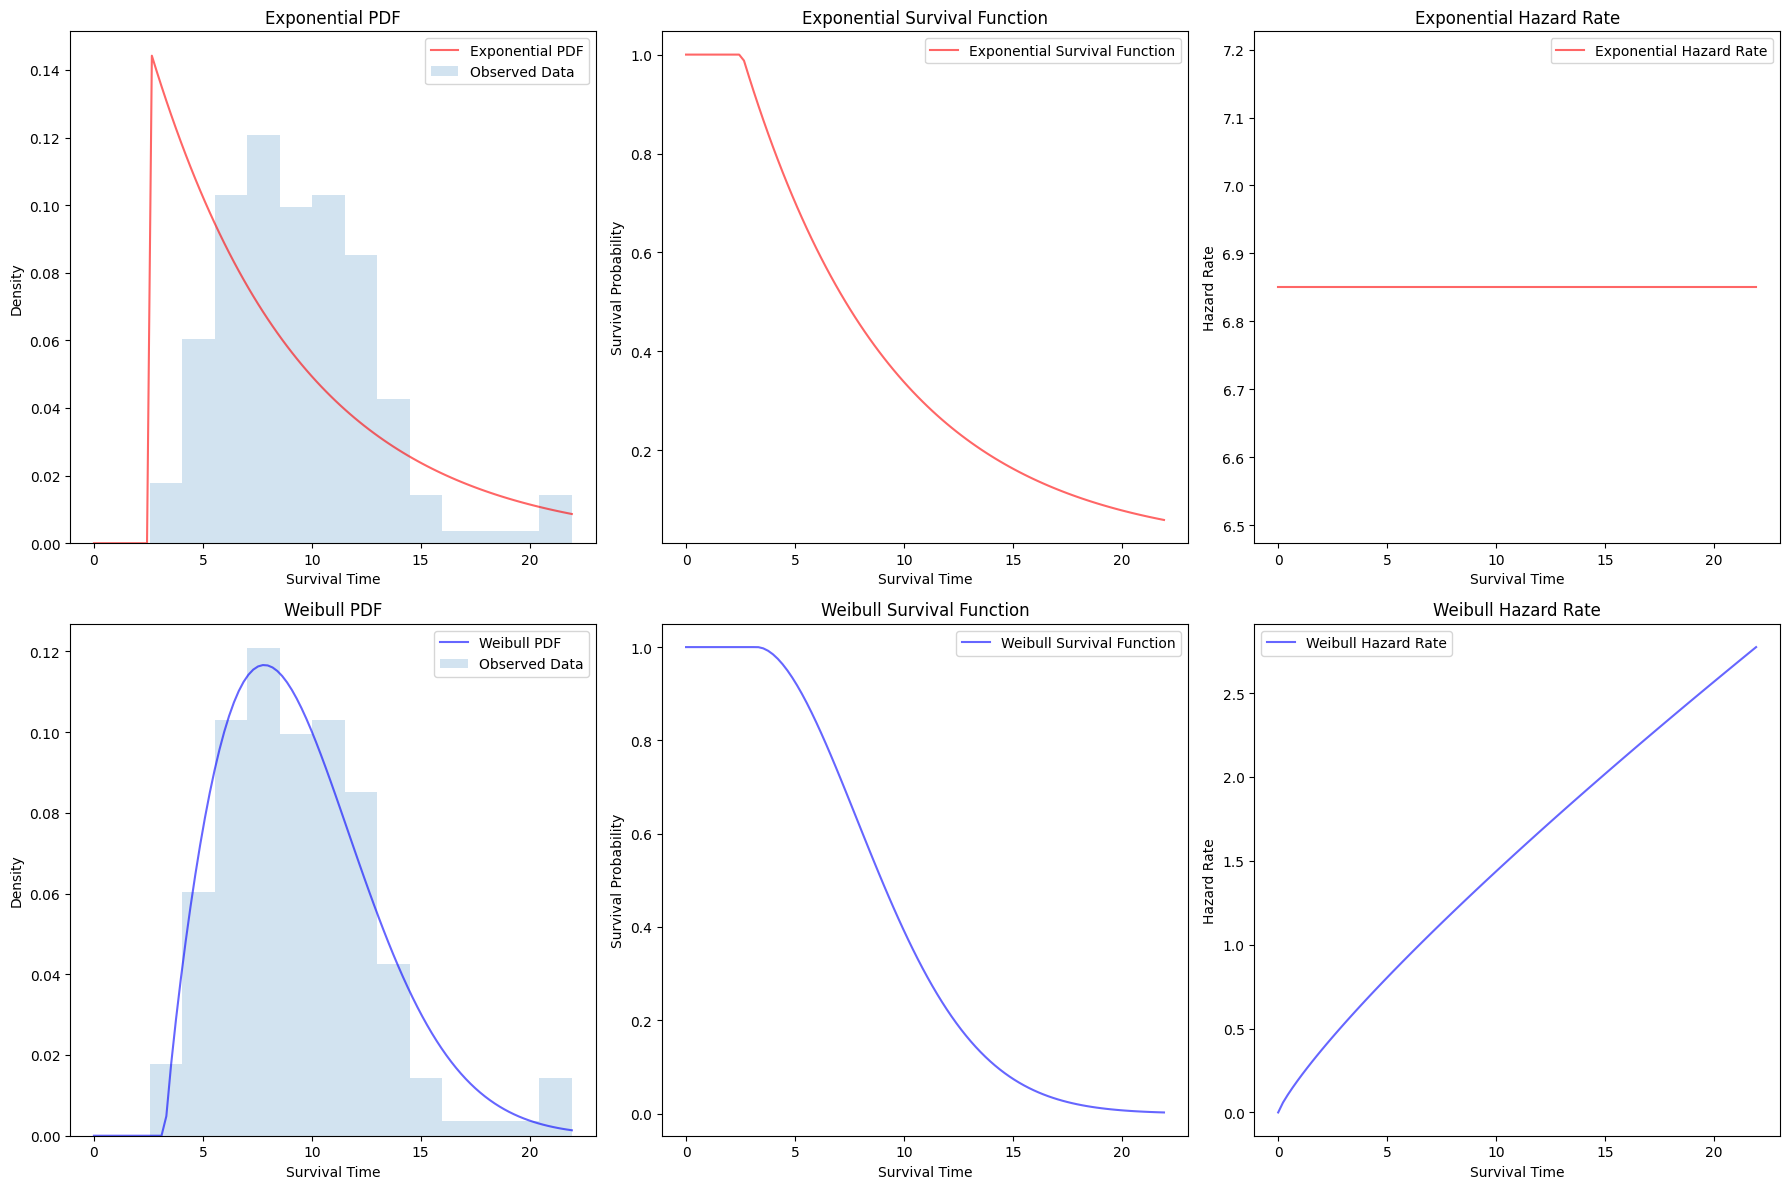

In [21]:
from scipy.stats import expon, weibull_min

# Fit the exponential distribution to the entire dataset
exp_params = expon.fit(df["T"])
exp_RV = expon(*exp_params)

# Fit the Weibull distribution to the entire dataset
weibull_params = weibull_min.fit(df["T"])
weibull_RV = weibull_min(*weibull_params)

# Print the fitted parameters
print("Exponential Parameters:", exp_params)
print("Weibull Parameters:", weibull_params)

# Generate values for plotting
x = np.linspace(0, df["T"].max(), 100)

# Calculate PDFs and Survival Functions
exp_pdf = exp_RV.pdf(x)
exp_survival = exp_RV.sf(x)

weibull_pdf = weibull_RV.pdf(x)
weibull_survival = weibull_RV.sf(x)

# Calculate Hazard Rates
exp_hazard = np.full_like(x, exp_params[1])  # Constant hazard rate for exponential

weibull_hazard = (weibull_params[0] / weibull_params[1]) * (x / weibull_params[1])**(weibull_params[0] - 1)

# Plot PDFs, Survival Functions, and Hazard Rates
plt.figure(figsize=(18, 12))

# Exponential Distribution
plt.subplot(2, 3, 1)
plt.plot(x, exp_pdf, 'r-', alpha=0.6, label='Exponential PDF')
plt.hist(df["T"], density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='Observed Data')
plt.title('Exponential PDF')
plt.xlabel('Survival Time')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(x, exp_survival, 'r-', alpha=0.6, label='Exponential Survival Function')
plt.title('Exponential Survival Function')
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(x, exp_hazard, 'r-', alpha=0.6, label='Exponential Hazard Rate')
plt.title('Exponential Hazard Rate')
plt.xlabel('Survival Time')
plt.ylabel('Hazard Rate')
plt.legend()

# Weibull Distribution
plt.subplot(2, 3, 4)
plt.plot(x, weibull_pdf, 'b-', alpha=0.6, label='Weibull PDF')
plt.hist(df["T"], density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='Observed Data')
plt.title('Weibull PDF')
plt.xlabel('Survival Time')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(x, weibull_survival, 'b-', alpha=0.6, label='Weibull Survival Function')
plt.title('Weibull Survival Function')
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(x, weibull_hazard, 'b-', alpha=0.6, label='Weibull Hazard Rate')
plt.title('Weibull Hazard Rate')
plt.xlabel('Survival Time')
plt.ylabel('Hazard Rate')
plt.legend()

plt.tight_layout()
plt.show()


### Another way to calculate the Survival function is to use ECDF. 
#### this method allows us to calculate the survival rate from the data, even without assuming to what distribution it belongs.

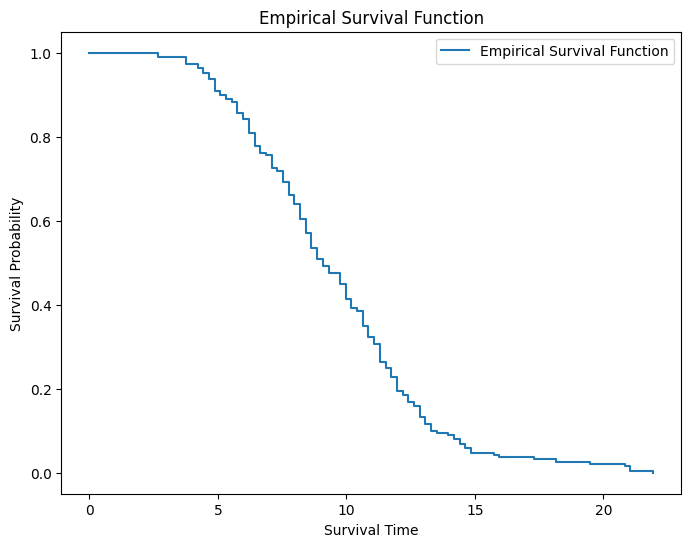

In [22]:
from statsmodels.distributions.empirical_distribution impt later.
ort ECDF

# Fit the empirical CDF to the data
ecdf = ECDF(df["T"])
# Calculate the empirical CDF values
x = np.linspace(0, df["T"].max(), 100)
ecdf_values = ecdf(x)
# Calculate the survival function
survival_function = 1 - ecdf_values

# Plot the empirical survival function
plt.figure(figsize=(8, 6))
plt.step(x, survival_function, where='post', label='Empirical Survival Function')
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.title('Empirical Survival Function')
plt.legend()
plt.show()


#### But, we need to remeber that we didn't take into acount all of the instances where E=0. for that, we can use Kaplan-Meier Estimator. 

          KM_estimate
timeline             
0.000000     1.000000
2.575538     0.994709
2.632264     0.989418
3.563581     0.984127
3.563830     0.978836


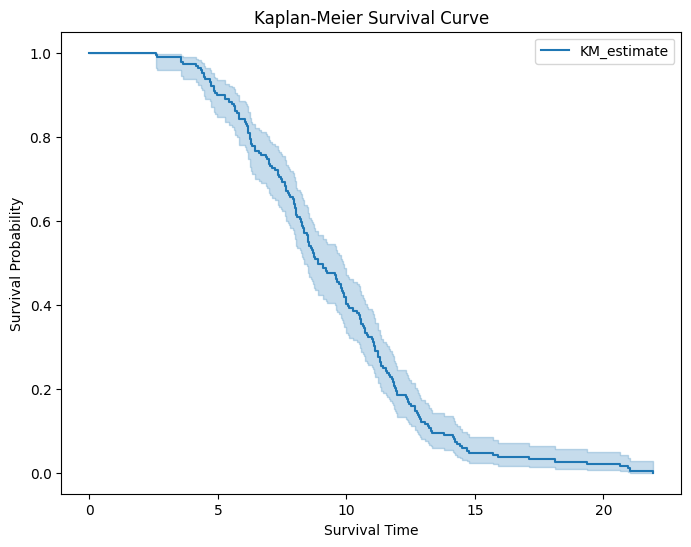

In [23]:
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df["T"], event_observed=df["E"])

# Print the survival function
print(kmf.survival_function_.head())

# Plot the Kaplan-Meier survival function
plt.figure(figsize=(8, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.show()


### If we want, we can compare more than group based on survival time.
#### let's set a threshold, which will be the mean of var1. with that we can compute the survival time for two groups, one above the mean and one below it. 

/tmp/ipykernel_1061745/166688563.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['var1'].apply(lambda x: 'Above Mean' if x > mean_var1 else 'Below or Equal to Mean')


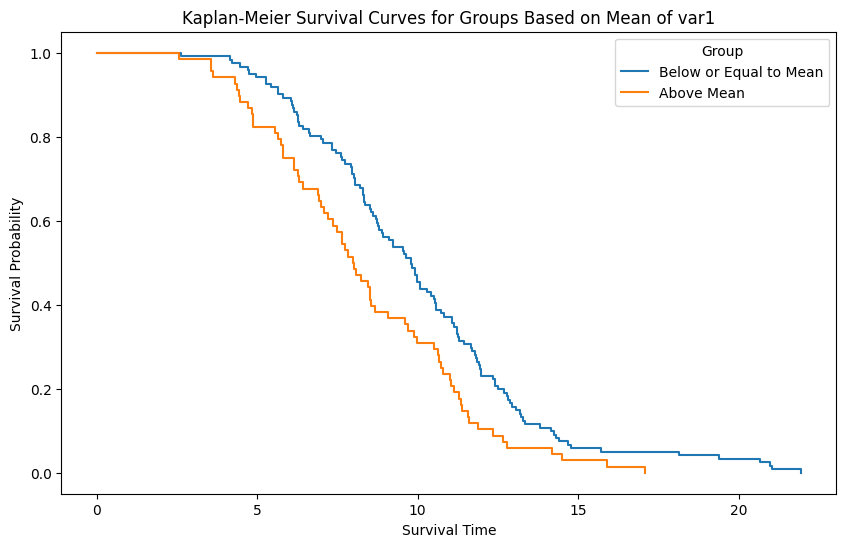

In [24]:
# Mean value of 'var1'
mean_var1 = 0.880716

# Create a group indicator based on the mean value
df['group'] = df['var1'].apply(lambda x: 'Above Mean' if x > mean_var1 else 'Below or Equal to Mean')

# Extract the unique groups
groups = df['group'].unique()

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Create a plot
plt.figure(figsize=(10, 6))

for group in groups:
    # Create boolean index for the current group
    group_idx = (df['group'] == group)
    
    # Fit Kaplan-Meier estimator for the current group
    kmf.fit(df[group_idx]["T"], df[group_idx]["E"], label=group)
    
    # Plot survival function for the current group without censor markers
    kmf.plot_survival_function(ci_show=False)  # Hide confidence intervals

# Customize the plot
plt.title('Kaplan-Meier Survival Curves for Groups Based on Mean of var1')
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.legend(title='Group')
plt.show()


#### We can now check if the differnce really is big with a statistical test:

In [25]:
# Create a group indicator based on the threshold
df['group'] = df['var1'].apply(lambda x: 'Above Threshold' if x > mean_var1 else 'Below or Equal to Threshold')

# Extract survival times for each group
group1_lifetimes = df[df['group'] == 'Above Threshold']['T']
group2_lifetimes = df[df['group'] == 'Below or Equal to Threshold']['T']

# Perform Mann-Whitney U test (non-parametric test suitable for comparing distributions)
u_stat, p_value = ss.mannwhitneyu(group1_lifetimes, group2_lifetimes, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

# Optional: If you still want to perform a t-test (considering assumptions are met)
t_stat, p_value_t = ss.ttest_ind(group1_lifetimes, group2_lifetimes, equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value (t-test): {p_value_t}")

U-statistic: 3012.0
P-value: 0.002274996302490748
T-statistic: -3.26385837528118
P-value (t-test): 0.0013489614168461666


/tmp/ipykernel_1061745/102256396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['var1'].apply(lambda x: 'Above Threshold' if x > mean_var1 else 'Below or Equal to Threshold')


#### Since p is big, we can say that there is no statistically significant difference in the means of survival times between the two groups

### Let's introduce a new method: Cox model.
#### cox model is used to visualize how the partial effect of a covariate affects the outcome of a Cox Proportional Hazards model.

/tmp/ipykernel_1061745/4219069666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['group'].replace({'Below or Equal to Threshold': 0, 'Above Threshold': 1})


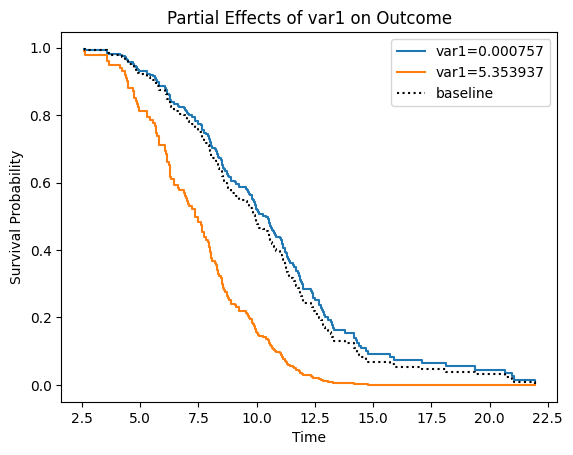

In [37]:
# Small fix, setting the "group" column to integer values.
df['group'] = df['group'].replace({'Below or Equal to Threshold': 0, 'Above Threshold': 1})

# Fit the Cox Proportional Hazards model
cph = lifelines.CoxPHFitter()
cph.fit(df, duration_col='T', event_col='E')

# Plot partial effects of the continuous covariate 'var1'
cph.plot_partial_effects_on_outcome(covariates='var1', values=[df['var1'].min(), df['var1'].max()])
plt.title('Partial Effects of var1 on Outcome')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()


#### By looking at the graph, we can tell that for higher values of var1, we have a better surviving chances.

### We can check if the cox model does suits our data by using "check_assumptions"

In [39]:
cph.check_assumptions(df)

Proportional hazard assumption looks okay.


[]

#### And does seems like it fits.